## LSTM 사용 Text 분류 모델 구현
: Keras의 Embedding,LSTM,Dropout 계층 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

###  Spam and Ham 분류 테스트 데이터 셋 읽어오기

In [2]:
df = pd.read_csv('spam.csv', delimiter=',',encoding='latin-1')
# ISO/IEC 8859-1, https://ko.wikipedia.org/wiki/ISO/IEC_8859-1
print(df.shape)
print(df['v2'][0], df['v1'][0])
df

(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


### 불필요한 컬럼 삭제

In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

### 분포를 시각화

Text(0, 0.5, 'Number of ham and spam messages')

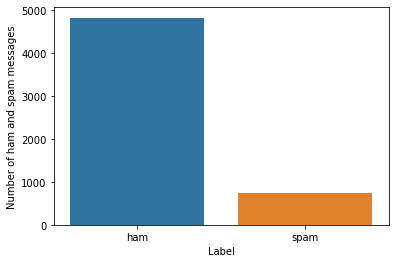

In [5]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.ylabel('Number of ham and spam messages')

### Y 값을 0, 1로 변환 : LabelEncoder()

In [6]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y) # Y 값이 0(ham),1(spam)로 변환, Logistic Regression, sigmoid사용
Y = Y.reshape(-1,1)     # 2차원
print(Y,Y.shape)

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]] (5572, 1)


In [7]:
### train 과 test 데이터 셋으로 분리
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)  # 70:30
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(3900,) (1672,) (3900, 1) (1672, 1)


### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

In [9]:
# 토큰나이저를 실행하여 단어를 숫자값, 인덱스로 변환하여 저장하고 문장을 벡터로 표현

max_words = 1000    # vocab_size , V
output_dim = 50     # D , hidden_size(Embedding), input_size(LSTM)
max_len = 150       # 문장의 길이 , sequence_length , T

tokenizer = Tokenizer(num_words=max_words)  # 가장 빈도가 높은 1000 개의 단어들만 사용하여 토큰화

# 단어 인덱스를 구축
tokenizer.fit_on_texts(X_train)  # 범위 : 1 ~ 1000

# 문자열을 정수 인덱스의 리스트로 변환, (문장을 정수로 인코딩)
sequences = tokenizer.texts_to_sequences(X_train)  # type은 list
print(sequences[:4])
# print(X_train[:4])

# word_to_index = tokenizer.word_index
# print(word_to_index)
# print(len(word_to_index)) # 7380

# zero 패딩을 한 벡터 표현을 얻음
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len) # 신경망에 입력할 X값이다
print(sequences_matrix.shape)  # (3900, 150)
sequences_matrix

[[106, 238, 40, 81, 12, 723, 21], [57, 25, 57, 18, 83, 79, 599, 8, 398, 845, 82, 166, 271, 8, 83, 399, 31, 263, 724, 11, 535, 20], [933, 12, 846, 846, 12, 725, 725, 12, 272, 272, 12, 6, 25, 6, 12, 10, 68, 2, 46, 28, 199, 10, 32, 6, 56, 10, 32, 6, 33, 80, 116, 6, 77, 847, 9, 18, 6, 87, 121, 116, 2, 726, 152, 6, 77, 679, 18, 217, 41, 6, 188, 8, 344, 2, 6, 264, 14], [285, 81, 443, 34, 34, 48, 18, 82, 400, 239]]
(3900, 150)


array([[  0,   0,   0, ...,  12, 723,  21],
       [  0,   0,   0, ...,  11, 535,  20],
       [  0,   0,   0, ...,   6, 264,  14],
       ...,
       [  0,   0,   0, ...,   7, 254, 119],
       [  0,   0,   0, ...,   4,  55,  64],
       [  0,   0,   0, ...,  26, 307,  82]])

## RNN 신경망 모델 구현

In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
# tf.keras.layers.Embedding(
#     input_dim, output_dim, embeddings_initializer='uniform',
#     embeddings_regularizer=None, activity_regularizer=None,
#     embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

# input_dim : input_dim   , V  ,     max_words : 1000
# output_dim : hidden_size , D ,               : 50
# input_length : sequence_length , T : max_len : 150

In [11]:
# tf.keras.layers.LSTM(
#     units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
#     kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
#     bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
#     recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#     kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
#     dropout=0.0, recurrent_dropout=0.0, implementation=2, return_sequences=False,
#     return_state=False, go_backwards=False, stateful=False, time_major=False,
#     unroll=False, **kwargs
# )

# return_sequences=True  이면 3차원(N,T,H)로 출력
# return_sequences=False 이면 2차원(N,H)로 출력, 마지막 줄만 반환

In [12]:
# # LSTM 1층을 사용하여 신경망을 구현  :  [ Accuracy: 0.984 ]
# model = tf.keras.Sequential([
#     # X: (N, D)     , W: (V, D)     --> (N,T,D)
#     # X: (None,150) , W: (1000,50)  --> (None,150,50)
#     tf.keras.layers.Embedding(max_words,output_dim,input_length=max_len),
#     tf.keras.layers.LSTM(units=32,return_sequences=True), # 3차원으로 출력 ,(None,150,32)
#     tf.keras.layers.Dense(32, activation='relu'),         # 3차원으로 출력 ,(None,150,32)
#     tf.keras.layers.Dropout(rate=0.5),                    # 3차원으로 출력 ,(None,150,32)
#     tf.keras.layers.Flatten(),                            # 2차원으로 출력 ,(None,150*32)=(None,4800)
#     tf.keras.layers.Dense(1,activation='sigmoid')         # 2차원으로 출력 ,(None,1)
# ])

# model.summary()

In [13]:
# LSTM 2층을 사용하여 신경망을 구현 :  [ Accuracy: 0.985 ]  # 2층의 정확도가 약간 높다
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words,output_dim,input_length=max_len),
    tf.keras.layers.LSTM(units=32,return_sequences=True), # 3차원으로 출력 ,(None,150,32)
    tf.keras.layers.LSTM(units=32),                       # 2차원으로 출력 ,(None,32)
    tf.keras.layers.Dense(32, activation='relu'),         # 2차원으로 출력 ,(None,32)
    tf.keras.layers.Dropout(rate=0.5),                    # 2차원으로 출력 ,(None,32)
    # tf.keras.layers.Flatten(),                         
    tf.keras.layers.Dense(1,activation='sigmoid')         # 2차원으로 출력 ,(None,1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 150, 32)           10624     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 70,033
Trainable params: 70,033
Non-trainable params: 0
____________________________________________________

In [14]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# RMSProp : https://forensics.tistory.com/28
# RMSprop 알고리즘은 Adadelta와 마찬가지로 Adagrad에서 학습률이 급격하게 감소하는 문제를 해결 

In [15]:
# 학습
model.fit(sequences_matrix,Y_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 3s 133ms/step - loss: 0.4532 - accuracy: 0.8417 - val_loss: 0.2636 - val_accuracy: 0.8731
Epoch 2/10
25/25 [==============================] - 3s 109ms/step - loss: 0.2116 - accuracy: 0.9224 - val_loss: 0.1323 - val_accuracy: 0.9667
Epoch 3/10
25/25 [==============================] - 3s 103ms/step - loss: 0.1108 - accuracy: 0.9798 - val_loss: 0.1198 - val_accuracy: 0.9679
Epoch 4/10
25/25 [==============================] - 3s 101ms/step - loss: 0.0692 - accuracy: 0.9853 - val_loss: 0.0848 - val_accuracy: 0.9795
Epoch 5/10
25/25 [==============================] - 2s 100ms/step - loss: 0.0567 - accuracy: 0.9869 - val_loss: 0.0622 - val_accuracy: 0.9833
Epoch 6/10
25/25 [==============================] - 3s 101ms/step - loss: 0.0462 - accuracy: 0.9904 - val_loss: 0.0763 - val_accuracy: 0.9833
Epoch 7/10
25/25 [==============================] - 3s 109ms/step - loss: 0.0315 - accuracy: 0.9920 - val_loss: 0.1230 - val_accuracy: 0.9795
Epoch 

### 정확도 측정

In [16]:
#  Test 데이터셋의 벡터를 구함

# 문자열을 정수 인덱스의 리스트로 변환, (문장을 정수로 인코딩)
test_sequences = tokenizer.texts_to_sequences(X_test)  # type은 list

# zero 패딩을 한 벡터 표현을 얻음
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len) 
print(test_sequences_matrix.shape, Y_test.shape)  # (1672, 150)

(1672, 150) (1672, 1)


In [17]:
# 정확도
accr = model.evaluate(test_sequences_matrix, Y_test)

53/53 [==============================] - 1s 15ms/step - loss: 0.0883 - accuracy: 0.9850


In [18]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.088
  Accuracy: 0.985


In [19]:
# 예측
preds = model.predict(test_sequences_matrix[1].reshape(1,-1))
print(preds,Y_test[1])

[[1.540048e-05]] [0]


In [20]:
test_sequences_matrix[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 621, 789,  95, 272, 845,  47, 250,   8,   9,  14,  25,
        14, 185,  47, 250, 989,  14, 930])

In [21]:
preds = model.predict(test_sequences_matrix[17].reshape(1,-1))
print(preds,Y_test[17])

[[8.328391e-05]] [0]


In [22]:
ones = np.where(Y_test==1)  # 답이 1인 인덱스
ones[0]

array([   4,    5,    8,   13,   21,   27,   28,   35,   59,   65,   67,
         70,   74,   85,   89,  103,  113,  118,  125,  132,  144,  145,
        151,  154,  156,  170,  173,  187,  205,  220,  231,  243,  249,
        250,  251,  254,  257,  260,  267,  269,  272,  276,  281,  294,
        331,  350,  357,  360,  364,  372,  373,  377,  378,  385,  404,
        412,  431,  446,  449,  464,  469,  472,  477,  480,  494,  496,
        499,  504,  505,  511,  527,  536,  557,  569,  573,  579,  594,
        603,  604,  619,  628,  629,  633,  643,  649,  654,  659,  660,
        661,  671,  674,  685,  691,  701,  706,  708,  709,  736,  737,
        739,  743,  745,  747,  750,  753,  762,  764,  769,  771,  781,
        792,  793,  798,  806,  820,  823,  825,  836,  840,  850,  855,
        856,  870,  871,  881,  902,  921,  930,  944,  945,  946,  948,
        955,  960,  982,  985,  986,  987,  998, 1015, 1017, 1018, 1023,
       1039, 1059, 1068, 1075, 1081, 1082, 1092, 11

In [23]:
for one in ones[0]:
    preds = model.predict(test_sequences_matrix[one].reshape(1,-1))
    print(preds,Y_test[one])

[[0.9992803]] [1]
[[0.99898076]] [1]
[[0.9765587]] [1]
[[0.9991563]] [1]
[[0.9987993]] [1]
[[0.9993839]] [1]
[[0.99938595]] [1]
[[0.9993429]] [1]
[[0.9992351]] [1]
[[0.9989561]] [1]
[[0.9989613]] [1]
[[0.99934566]] [1]
[[0.99841785]] [1]
[[0.9994295]] [1]
[[0.9987035]] [1]
[[0.99177617]] [1]
[[0.99936473]] [1]
[[0.9992603]] [1]
[[0.9990052]] [1]
[[0.99814874]] [1]
[[0.9993796]] [1]
[[0.99933696]] [1]
[[0.9993174]] [1]
[[0.99925745]] [1]
[[0.9991669]] [1]
[[0.9993311]] [1]
[[0.992548]] [1]
[[0.9994]] [1]
[[0.992548]] [1]
[[0.07314533]] [1]
[[0.99877214]] [1]
[[0.00482464]] [1]
[[0.9994063]] [1]
[[0.9923465]] [1]
[[2.6318248e-05]] [1]
[[0.99927765]] [1]
[[0.99936676]] [1]
[[0.99364203]] [1]
[[0.99905187]] [1]
[[0.99844927]] [1]
[[0.9989385]] [1]
[[0.9376961]] [1]
[[0.99816316]] [1]
[[0.9687518]] [1]
[[0.99936795]] [1]
[[0.99903584]] [1]
[[0.9994186]] [1]
[[0.99928963]] [1]
[[0.99936366]] [1]
[[0.99927986]] [1]
[[0.58557886]] [1]
[[0.9992217]] [1]
[[0.9993171]] [1]
[[0.9990705]] [1]
[[0.9